# git clone

In [1]:
!git clone https://github.com/ubermenchh/miniai.git

Cloning into 'miniai'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 71 (delta 23), reused 51 (delta 11), pack-reused 0
Receiving objects: 100% (71/71), 1.14 MiB | 19.81 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [ ]:
!pip install -e miniai

In [3]:
!pip install -qU torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

# Initializing

In [1]:
#|default_exp init

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [5]:
def get_model():
    return nn.Sequential(
        conv(1, 8),
        conv(8, 16),
        conv(16, 32),
        conv(32, 64),
        conv(64, 10, act=False),
        nn.Flatten()
    ).to(def_device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


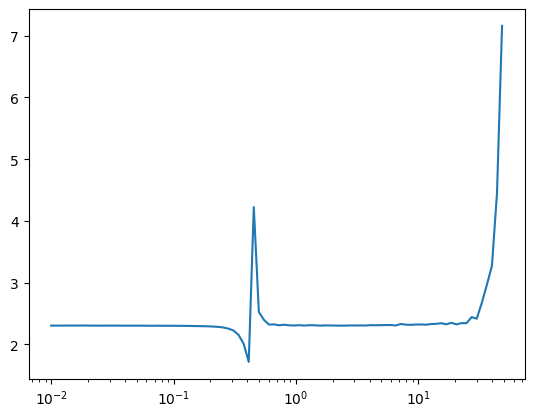

In [6]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.224,2.137,0,train
0.315,1.997,0,eval


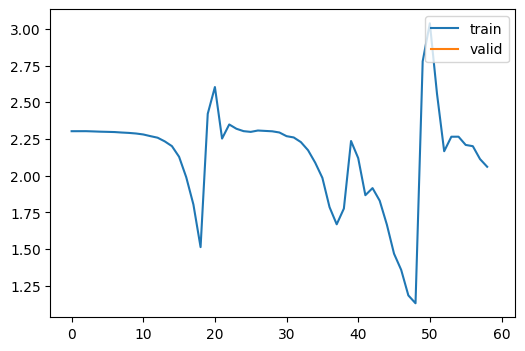

In [8]:
learn.fit(1)

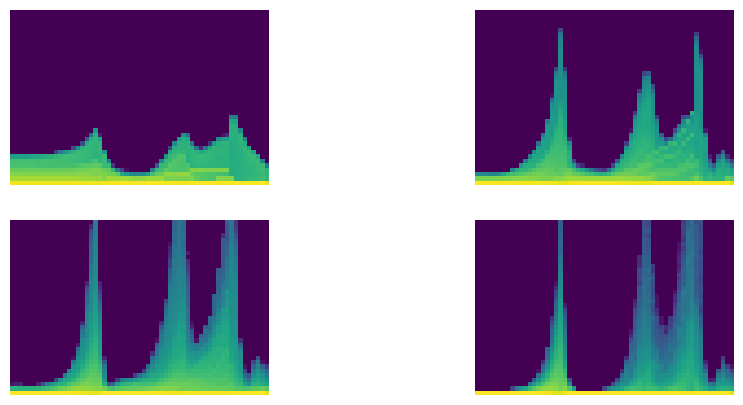

In [9]:
astats.color_dim()

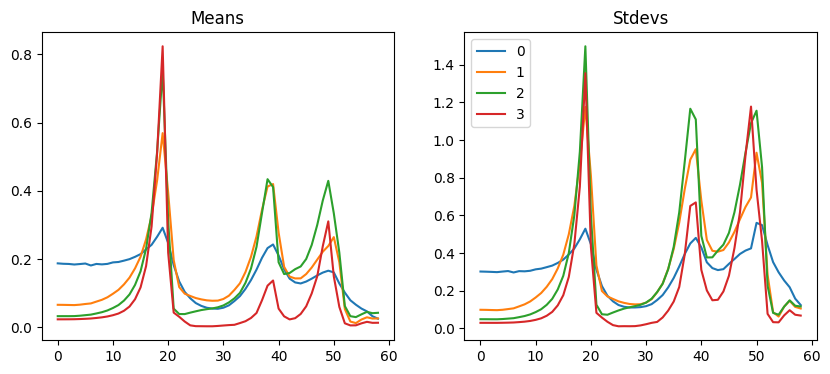

In [10]:
astats.plot_stats()

In [11]:
#|export
def clean_ipython_hist():
    if not "get_ipython" in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc):
        user_ns.pop("_i" + repr(n), None)
    user_ns.update(dict(_i="", _ii="", _iii=""))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [""] * pc
    hm.input_hist_raw[:] = [""] * pc
    hm._i = hm._ii = hm._iii = hm._100 = ""

In [12]:
#|export
def clean_tb():
    if hasattr(sys, "last_traceback"):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, "last_traceback")
    if hasattr(sys, "last_type"): delattr(sys, "last_type")
    if hasattr(sys, "last_value"): delattr(sys, "last_value")

In [13]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

## Glorot/Xavier Init

In [14]:
x = torch.randn(200, 100)
for i in range(50):
    x = x @ torch.randn(100, 100)
x[0:5, 0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

In [15]:
x = torch.randn(200, 100)
for i in range(50):
    x = x @ (torch.randn(100, 100) * 0.01)
x[0:5, 0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [16]:
x = torch.randn(200, 100)
for i in range(50):
    x = x @ (torch.randn(100, 100) * 0.1)
x[0:5, 0:5]

tensor([[ 1.33, -1.54,  0.54,  0.13,  3.51],
        [ 0.20,  0.95,  0.61, -0.02,  1.73],
        [-0.69,  1.72,  0.36, -0.64, -2.40],
        [ 0.03,  0.73,  0.40, -1.24, -0.64],
        [ 0.33, -0.33,  0.03, -0.32,  0.62]])

## Xavier init Derivation

In [17]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(0.19), tensor(0.89))

In [18]:
mean, sqr = 0., 0.
for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr += y.pow(2).mean().item()
mean / 100, sqr / 100

(-0.03755951955914497, 103.38357582092286)

In [19]:
mean, sqr = 0., 0.
for i in range(10000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a @ x
    mean += y.item()
    sqr += y.pow(2).item()
mean / 10000, sqr / 10000

(-0.003068654421976953, 0.9694204860871445)

## Kaiming/He init

In [20]:
x = torch.randn(200, 100)
y = torch.randn(100)

In [21]:
from math import sqrt

In [22]:
w1 = torch.randn(100, 50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50, 1)   / sqrt(50)
b2 = torch.zeros(1)

In [23]:
def lin(x, w, b): return x @ w + b

In [24]:
l1 = lin(x, w1, b1)
l1.mean(), l1.std()

(tensor(-0.00), tensor(1.00))

In [27]:
def relu(x): return x.clamp_min(0.)

In [28]:
l2 = relu(l1)
l2.mean(), l2.std()

(tensor(0.40), tensor(0.58))

In [29]:
x = torch.randn(200, 100)
for i in range(50):
    x = relu(x @ torch.randn(100, 100) * 0.1)
x[0:5, 0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In [30]:
x = torch.randn(200, 100)
for i in range(50):
    x = relu(x @ torch.randn(100, 100) * sqrt(2/100))
x[:5, :5]

tensor([[0.54, 0.49, 0.53, 0.45, 0.18],
        [0.28, 0.34, 0.27, 0.38, 0.04],
        [0.50, 0.73, 0.44, 0.88, 0.07],
        [0.83, 0.90, 0.87, 0.84, 0.20],
        [0.35, 0.47, 0.22, 0.56, 0.03]])

In [31]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [32]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)): init.kaiming_normal_(m.weight)

In [33]:
model.apply(init_weights);

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


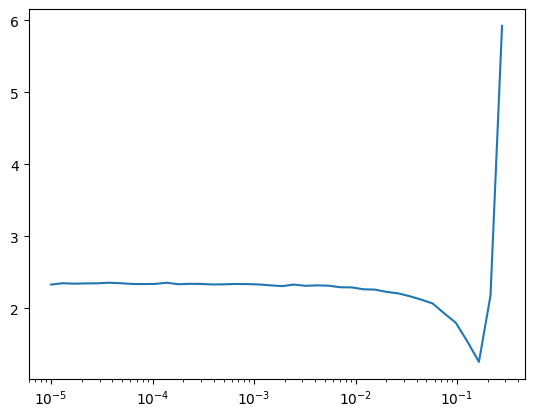

In [34]:
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

In [35]:
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.232,2.422,0,train
0.308,1.961,0,eval
0.545,1.243,1,train
0.775,0.589,1,eval
0.802,0.533,2,train
0.808,0.512,2,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


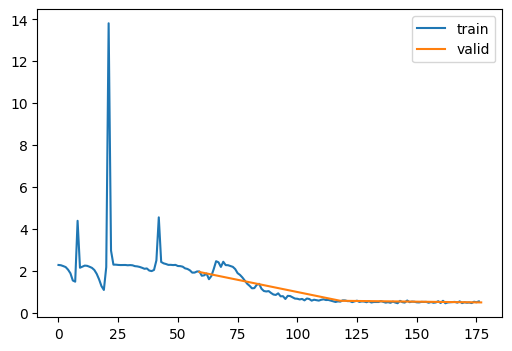

In [36]:
learn.fit(3)

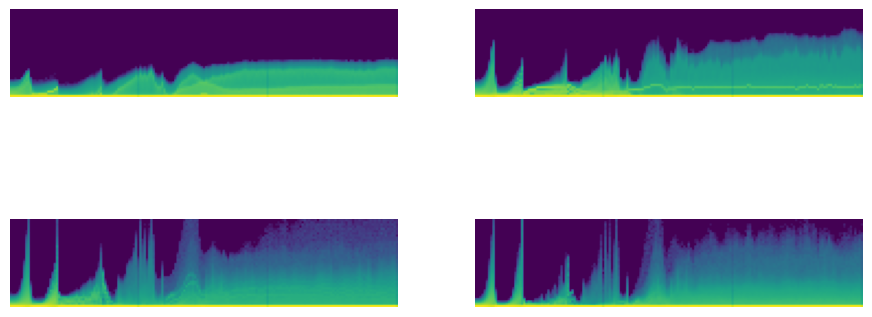

In [37]:
astats.color_dim()

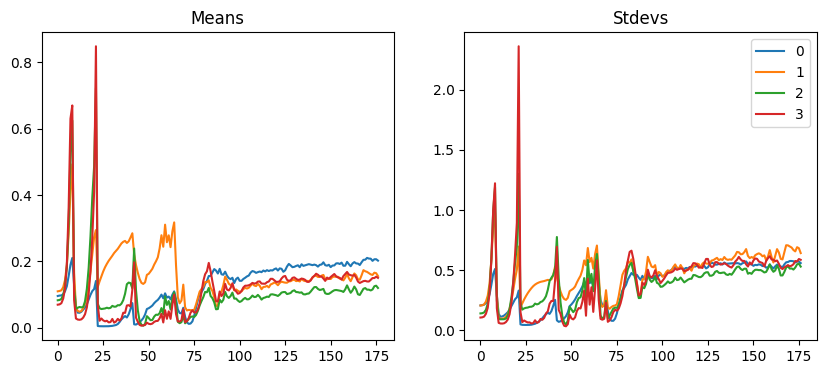

In [38]:
astats.plot_stats()

## Input Normalization

In [39]:
xmean, xstd = xb.mean(), xb.std()
xmean, xstd

(tensor(0.29), tensor(0.35))

In [40]:
#|export
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=False): fc.store_attr()
    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [41]:
def _norm(b): return (b[0] - xmean) / xstd, b[1]
norm = BatchTransformCB(_norm)

accuracy,loss,epoch,train
0.577,1.253,0,train
0.177,2.597,0,eval
0.816,0.500,1,train
0.200,2.802,1,eval
0.842,0.433,2,train
0.174,3.037,2,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


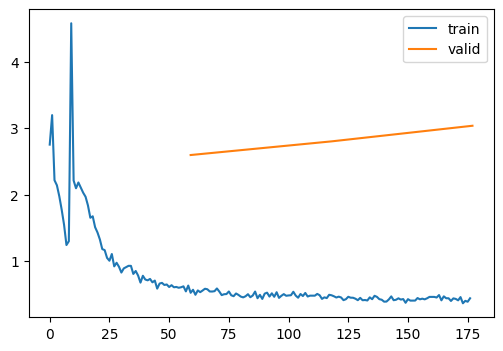

In [42]:
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])
learn.fit(3)

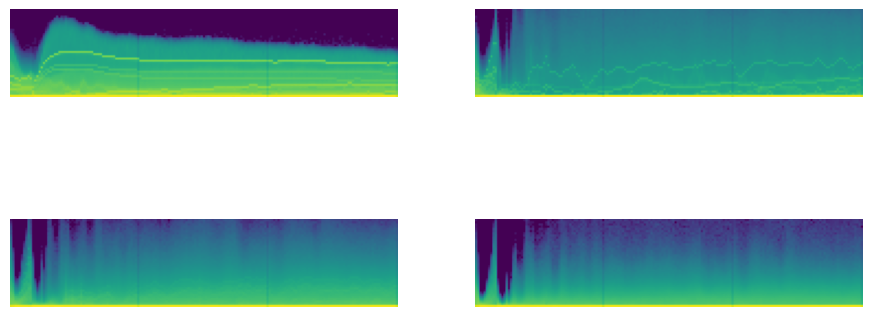

In [43]:
astats.color_dim()

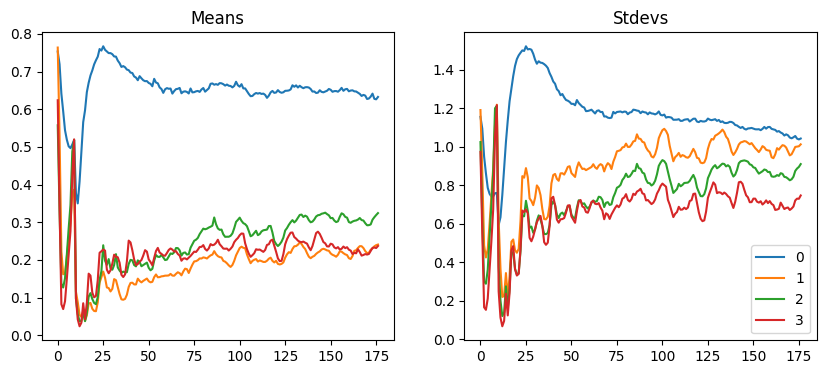

In [44]:
astats.plot_stats()

In [45]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o) - xmean) / xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
xb, yb = next(iter(dls.train))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [46]:
xb.mean(), xb.std()

(tensor(-0.01), tensor(0.99))

## General ReLU

In [47]:
#|export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv

    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu()
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [48]:
#| export
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

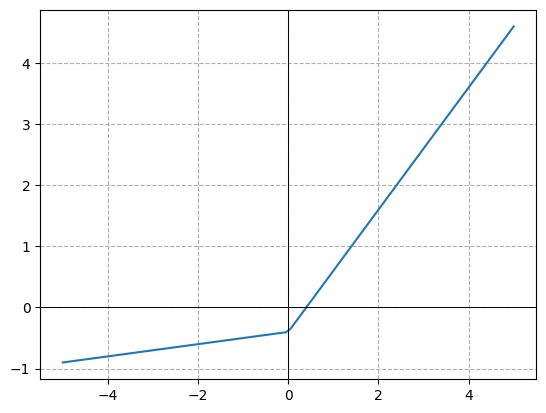

In [49]:
plot_func(GeneralRelu(leak=0.1, sub=0.4))

In [50]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [51]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs) - 1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None), nn.Flatten()).to(def_device)

In [57]:
#|export
def init_weights(m, leak=0.):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)): init.kaiming_normal_(m.weight, a=leak)

In [58]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leak=0.1)

In [59]:
model = get_model(act_gr).apply(iw)

accuracy,loss,epoch,train
0.765,0.666,0,train
0.835,0.437,0,eval
0.867,0.363,1,train
0.863,0.372,1,eval
0.884,0.318,2,train
0.873,0.348,2,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


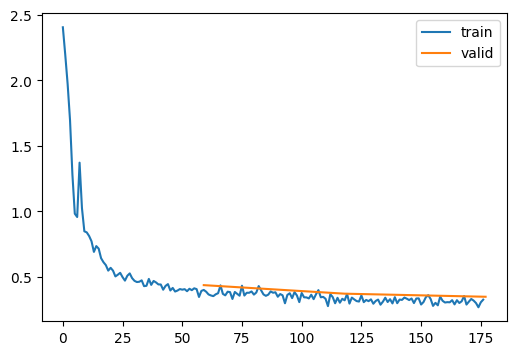

In [60]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

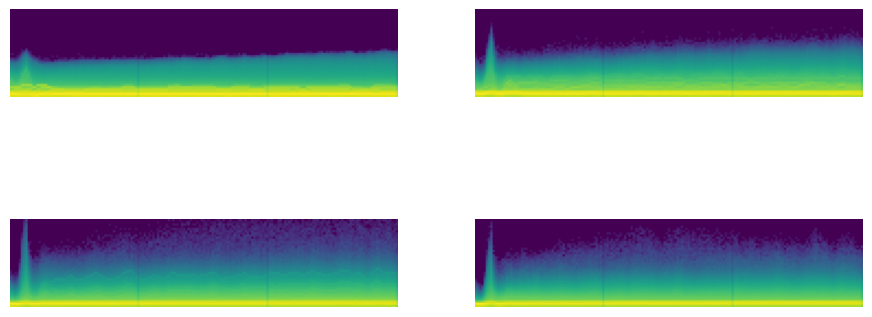

In [61]:
astats.color_dim()

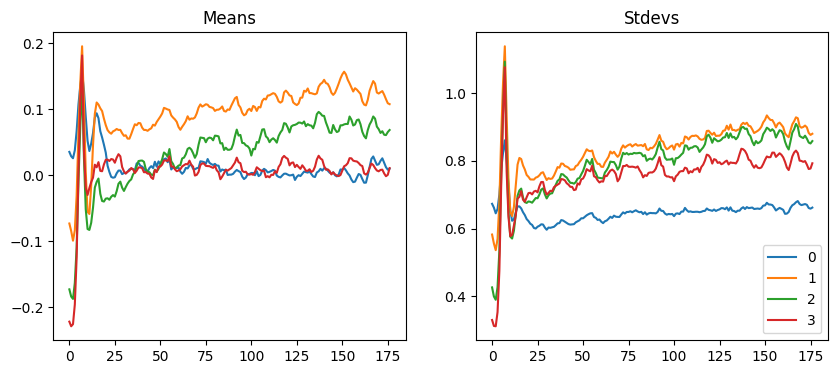

In [62]:
astats.plot_stats()

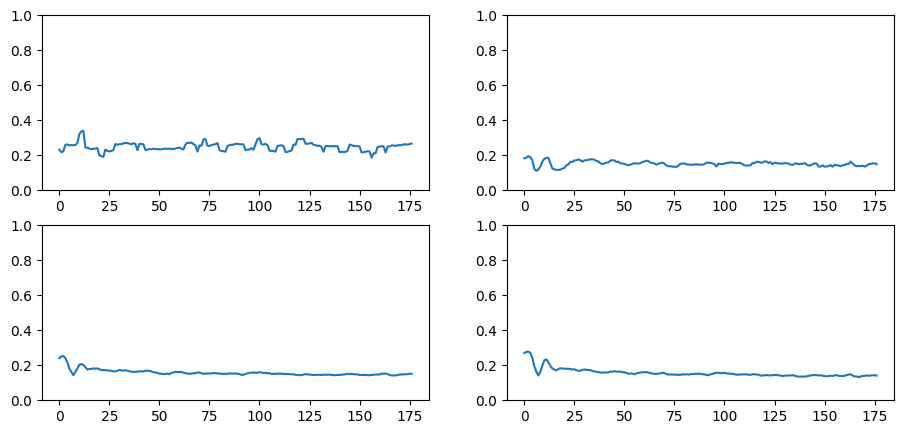

In [63]:
astats.dead_chart()

## LSUV

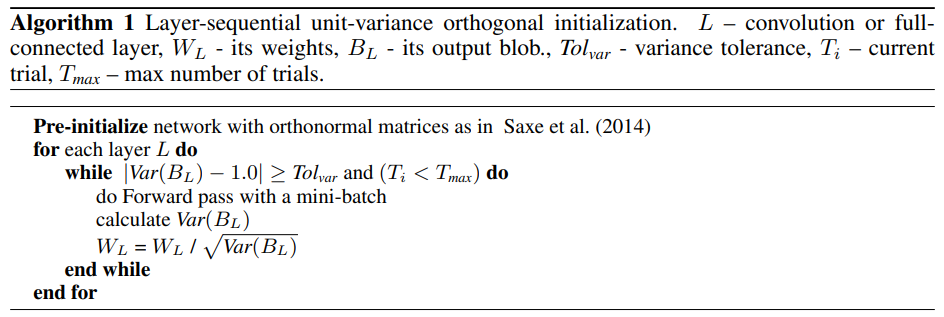

In [64]:
#|export
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()

def lsuv_init(model, m, m_in, xb):
    h = Hook(m, _lsuv_stats)
    with torch.inference_mode():
        while model(xb) is not None and (abs(h.std - 1) > 1e-3 or abs(h.mean) > 1e-3):
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
    h.remove()

In [65]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [66]:
for ms in zip(relus, convs): print(ms)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [67]:
for ms in zip(relus, convs):
    lsuv_init(model, *ms, xb.to(def_device))

accuracy,loss,epoch,train
0.769,0.645,0,train
0.834,0.449,0,eval
0.860,0.381,1,train
0.862,0.384,1,eval
0.877,0.337,2,train
0.868,0.368,2,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


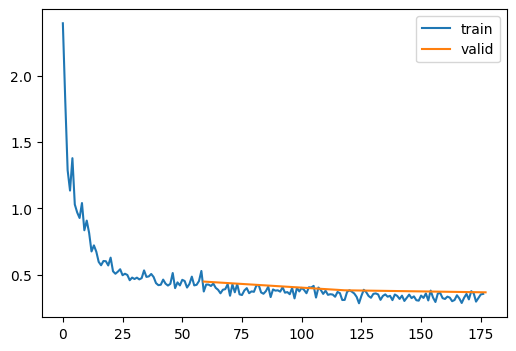

In [68]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

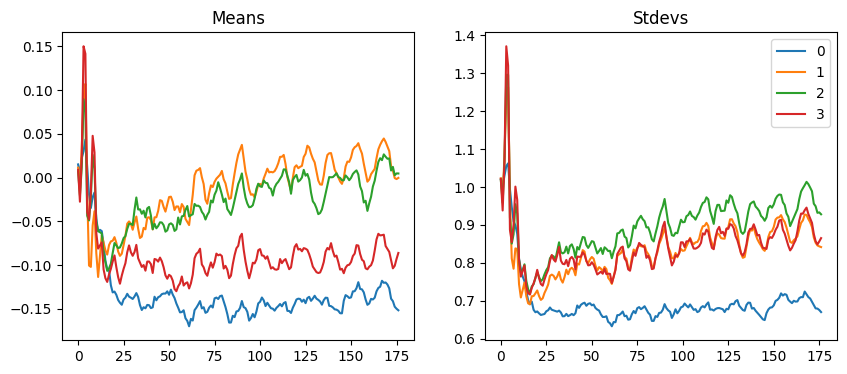

In [69]:
astats.plot_stats()

## Batch Normalization

### LayerNorm

In [70]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1, 2, 3), keepdim=True)
        v = x.var((1, 2, 3), keepdim=True)
        x = (x - m) / ((v + self.eps).sqrt())
        return x * self.mult + self.add

In [71]:
#|export
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [72]:
#|export
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs) - 1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=False, bias=True), nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.764,0.670,0,train
0.840,0.440,0,eval
0.861,0.377,1,train
0.863,0.381,1,eval
0.880,0.328,2,train
0.866,0.368,2,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


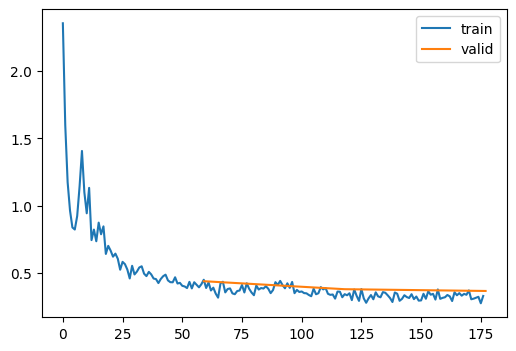

In [73]:
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

### BatchNorm

In [75]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer("vars", torch.ones(1, nf, 1, 1))
        self.register_buffer("means", torch.zeros(1, nf, 1, 1))

    def update_stats(self, x):
        m = x.mean((0, 2, 3), keepdim=True)
        v = x.var((0, 2, 3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m, v

    def forward(self, x):
        if self.training:
            with torch.inference_mode(): m, v = self.update_stats(x)
        else:
            m, v = self.means, self.vars
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mults + self.adds

accuracy,loss,epoch,train
0.798,0.548,0,train
0.808,0.561,0,eval
0.869,0.356,1,train
0.858,0.392,1,eval
0.884,0.314,2,train
0.856,0.386,2,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


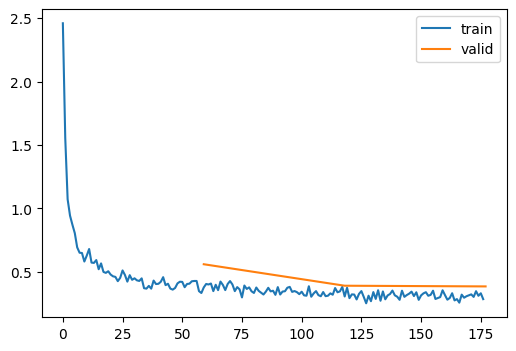

In [76]:
model = get_model(act_gr, norm=BatchNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

## Towards 90%..

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


accuracy,loss,epoch,train
0.836,0.451,0,train
0.856,0.384,0,eval
0.887,0.308,1,train
0.878,0.326,1,eval
0.897,0.274,2,train
0.886,0.318,2,eval


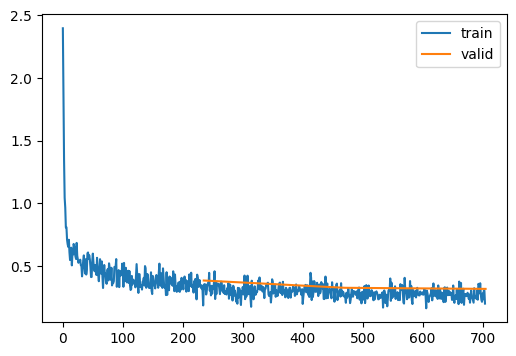

In [77]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.921,0.217,0,train
0.896,0.283,0,eval
0.925,0.203,1,train
0.903,0.275,1,eval


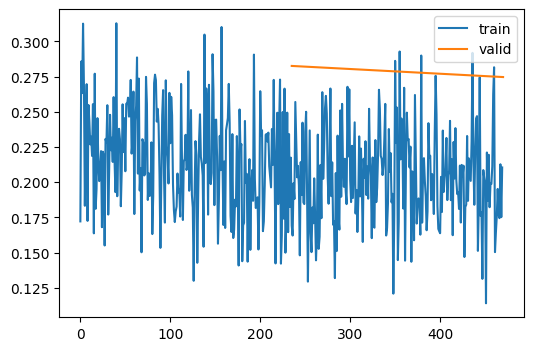

In [78]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)

# Export -

In [ ]:
import nbdev
nbdev.nbdev_export()